# Qubit-utilization quantum k-means clustering algorithm
This is the program for classifying the dataset into k clusters with the help of a quantum computer. In detail, I used the quantum computer to calculate the distance between the data point and the clusters' centroids. However, instead of calculating one distance at the same time, I will calculate several distances simultaneously so that the program can utilize as many qubits in the quantum circuit as possible.
To run this program, please follow these steps:
* Download the file.
* Install Qiskit, following this instruction: https://docs.quantum.ibm.com/start/install#local
* Install sklearn using this command: `pip install scikit-learn`
* [Optional] if you want to run the program on noisy simulator, install Qiskit Aer using this command: `pip install qiskit-aer`
* Restart Kernel and Run All Cells

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
""" Create an account in IBM Quantum Platform https://quantum.ibm.com/ to obtain your own token"""
QiskitRuntimeService.save_account(channel="ibm_quantum", 
                                  token="<YOUR TOKEN>",
                                  set_as_default=True, overwrite=True)
service = QiskitRuntimeService()

qiskit_runtime_service.__init__:INFO:2024-04-21 07:42:03,895: Default instance: ibm-q/open/main


In [2]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Iris dataset
* Import the Iris dataset to test the algorithm. 
* Reduce the dimension of the dataset to 2 dimensions.
* Transfer the dataset to list type

# Classical program
Construct classical program which calculating Euclidean distance for comparision with quantum program

In [3]:
def classical_distance(point_1, point_2):
    """
    Classically calculate the Euclidean distance between 2 points
    """
    euclidean_distance = math.sqrt((point_1[0] - point_2[0]) ** 2 + (point_1[1] - point_2[1]) ** 2)
    return euclidean_distance

# Quantum program
1. Prepare functions to be used in the main algorithms

In [4]:
def nearest_centroids_dictionary(dataset, centroids):
    """Construct a dictionary to store the information on nearest centroid for each point in the dataset"""
    nearest_centroids = {}
    for idx, data_point in enumerate(dataset):
        nearest_centroid = {
            'data point': data_point,
            'smallest distance': float('inf'),
            'nearest centroid': None,
            'unvisited centroids': centroids
        }
        nearest_centroids[idx] = nearest_centroid
    return nearest_centroids
"""
Construct functions for changing Cartesian coordinate to Polar coordinate
"""
def polar_angle(point):
    """
    Calculating polar angle
    """
    polar_angle = math.atan2(point[1], point[0])
    return polar_angle

def polar_radius(point):
    """
    Calculating polar coordinate
    """
    polar_radius = math.sqrt(point[0] ** 2 + point[1] ** 2)
    return polar_radius
    
def initialize_clusters(k, dataset):
    """
    Initialize clusters dictionary with randomly selected centroids
    
    Reference
    https://www.geeksforgeeks.org/k-means-clustering-introduction/
    """
    clusters = {}
    for idx in range(k):
        num_features = len(dataset[0])  # Number of features in the dataset
        center = (2*(2*np.random.random((num_features,))-1)).tolist()
        cluster = {
            'centroid': center,
            'points': []
    }
        clusters[idx] = cluster
    return clusters

def recompute_centroids(clusters):
    """
    Construct function for recomputing centroids as the average of values in the clusters
    """
    is_equal = True
    for cluster_id, cluster in clusters.items():
        if len(cluster['points']) > 0:
            new_centroid = np.mean(cluster['points'], axis=0).tolist()
            if new_centroid != cluster['centroid']:
                is_equal = False
                cluster['centroid'] = new_centroid
                cluster['points'] = []
    return clusters, is_equal

def quantum_circuit(qc, qr, cr, i, data_angle, centroid_angle):
    qc.h(qr[i * 2])
    qc.cx(qr[i * 2], qr[i * 2 + 1])
    qc.ry(-abs(data_angle - centroid_angle), qr[i * 2 + 1])
    qc.cx(qr[i * 2], qr[i * 2 + 1])
    qc.ry(abs(data_angle - centroid_angle), qr[i * 2 + 1])
    # Inteferernce and measurement
    qc.h(qr[i * 2])
    qc.measure(qr[i * 2], cr[i])
    return qc

def run_on_real_system(qc,backend_name='ibm_kyoto'):
    backend = service.get_backend(backend_name)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    circuit = pm.run(qc)
    sampler = Sampler(backend)
    job = sampler.run([circuit], shots=1024)
    return job

def run_on_noisy_simulator(qc, backend_name='ibm_kyoto'):
    real_backend = service.backend(backend_name)
    aer = AerSimulator.from_backend(real_backend)
    pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
    circuit = pm.run(qc)
    sampler = Sampler(backend=aer)
    job = sampler.run([circuit], shots=1024)
    return job

def run_on_ideal_simulator(qc):
    sampler = StatevectorSampler()
    job = sampler.run([qc], shots=1024)
    return job

def run_on_cloud_simulator(qc):
    simulator = service.get_backend("ibmq_qasm_simulator")
    job = simulator.run(qc, simulator, shots=1024)
    return job

def calculate_distance_quantumly(calculated_distances, nearest_centroids_dict):
    for idx, item in calculated_distances.items():
        probability_1 = item['count_1'] / 1024
        data = item['pair'][0]
        cen = item['pair'][1]
        # Calculate the distance from the probability of |1>
        data_radius = polar_radius(data)
        centroid_radius = polar_radius(cen)
        distance = math.sqrt(data_radius ** 2 + centroid_radius ** 2 - 2 * data_radius * centroid_radius * (1 - 2 * probability_1))
        # Update the nearest centroids dictionary
        for i, value in nearest_centroids_dict.items():
            if value['data point'] == data:
                if distance < value['smallest distance']:
                    value['smallest distance'] = distance
                    value['nearest centroid'] = cen
                unvisited_centroids_copy = value['unvisited centroids'][:]
                unvisited_centroids_copy.remove(cen)
                value['unvisited centroids'] = unvisited_centroids_copy
    return nearest_centroids_dict

2. Construct quantum function which:
* Quantumly calculating the distance between each data point and each centroid by utilizing as many available qubits in the quantum circuit as possible.
* Choosing the nearest centroids for each data point
* Updating the nearest_centroids_dictionary
* Returning a dictionary with the information about nearest centroid and corresponding smallest distance to the data point

There are 3 options to run the quantum circuit, including running on a real quantum system, on a noisy simulator that mimics the performance of a real system, and on the local ideal simulator.
* Use this function to run on a real quantum computer: `job = run_on_real_system(qc, 'ibm_kyoto')`
* Use this function to run on noisy simulator: `job = run_on_noisy_simulator(qc, 'ibm_kyoto')`
* Use this function to run on the local ideal simulator: `job = run_on_ideal_simulator(qc)`

In [5]:
def quantum_selection(dataset, centroids, num_qubits):
    # Calculate the number of distances can be calculated at the same time
    num_distances = 0
    num_distances, remainder = divmod(num_qubits, 2)
    # Initialize the dictionary containing information about nearest centroids for each data point
    nearest_centroids_dict = nearest_centroids_dictionary(dataset, centroids)
    # Loop until all the distances from each data point to each centroids are calculated
    while True:
        # Initialize quantum circuit
        qr = QuantumRegister(num_distances * 2, name="q")
        cr = ClassicalRegister(num_distances, name="c")
        qc = QuantumCircuit(qr, cr)
        # Initialize a dictionary contains all pairs of points whose distances are going to be calculated
        calculated_distances = {}
        i = 0
        for idx, item in nearest_centroids_dict.items():
            unvisited_centroids = item['unvisited centroids'][:]
            while (len(unvisited_centroids) > 0) and (len(calculated_distances) < num_distances):
                data_point = item['data point']
                data_angle = polar_angle(data_point)
                centroid = unvisited_centroids.pop()
                centroid_angle = polar_angle(centroid)
                qc = quantum_circuit(qc, qr, cr, i, data_angle, centroid_angle)
                # Update the index and calculated_distances
                calculated_distances[i] = {'pair': [data_point, centroid], 'count_1': 0}
                i += 1
            if len(calculated_distances) >= num_distances:
                break
        # Run the quantum circuit. Change the following line of code if you want to run on different system
        job = run_on_cloud_simulator(qc)
        result = job.result()
        count = result.get_counts(qc)
        state_list = list(count.keys())
        for state in state_list:
            state_count = count.get(state, 0)
            for idx, bit in enumerate(state):
                if bit == '1':
                    if (len(calculated_distances.items()) - idx - 1) >= 0:
                        calculated_distances[len(calculated_distances.items()) - idx - 1]['count_1'] += state_count
        nearest_centroids_dict = calculate_distance_quantumly(calculated_distances, nearest_centroids_dict)
        # Check if the distances from all points to all centroids are calculated
        is_finished = True
        for idx, item in nearest_centroids_dict.items():
            if len(item['unvisited centroids']) > 0:
                is_finished = False
        if is_finished == True:
            break
    return nearest_centroids_dict

3. Initialize clusters dictionary with randomly selected centroids

In [6]:
def quantum_k_means_clustering(k, dataset, num_qubits):
    # Initialize empty clusters with randomly chosen centroids:
    clusters = initialize_clusters(k, dataset)
    # Initialize variable which indicates whether the program has generated
    # k clusters properly
    is_convergence = False
    # Loop until convergence
    while not is_convergence:
        # List all centroids read from clusters dictionary
        centroids = []
        for cluster_id, cluster in clusters.items():
            centroids.append(cluster['centroid'])
        # Run quantum circuit to select nearest centroids for each data point
        nearest_centroids_dict = quantum_selection(dataset, centroids, num_qubits)
        for idx, item in nearest_centroids_dict.items():
            data_point = item['data point']
            nearest_centroid = item['nearest centroid']
            for cluster_id, cluster in clusters.items():
                if cluster['centroid'] == nearest_centroid:
                    cluster['points'].append(data_point)
        # Check if enough clusters have been created
        is_k_clusters = True
        for cluster in clusters.values():
            if len(cluster['points']) == 0:
                is_k_clusters = False
        # If not enough clusters, repeat the upper task with another k randomly generated centroids
        if is_k_clusters == False:
            clusters = initialize_clusters(k, dataset)
            continue
        else:
            # Recompute centroids by averaging all the points
            new_clusters, is_equal = recompute_centroids(clusters)
            if is_equal == True:
                is_convergence = True
                break
            else:
                clusters = new_clusters
    return clusters

/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/ibm_backend.py:689: UserWarning: The backend ibmq_qasm_simulator does not support dynamic circuits.
  warnings.warn(f"The backend {self.name} does not support dynamic circuits.")


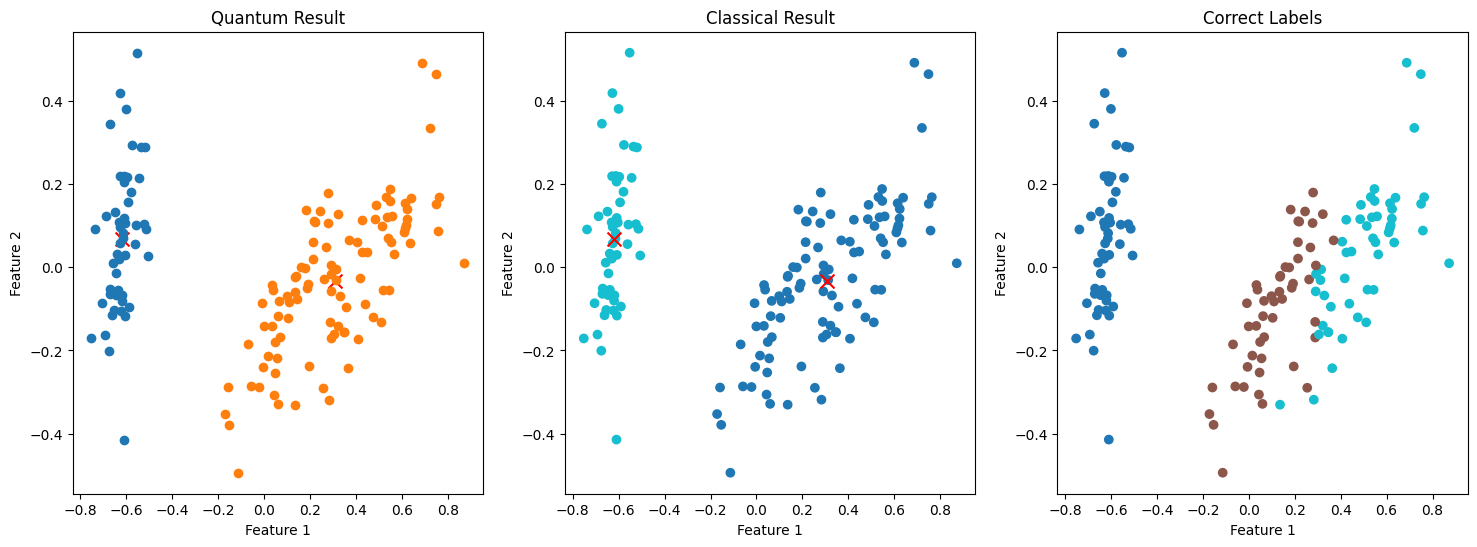

In [7]:
num_data = 150
num_clusters = 2
num_qubits = 30

# Import the Iris dataset
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
# Normalize the features
# Apply MinMaxScaler to map data onto (0, 1)
features = MinMaxScaler().fit_transform(features)
# Reduce the number of features
features = PCA(n_components=2).fit_transform(features)
# Select randomly num_data indices
random_indices = np.random.choice(len(features), size=num_data, replace=False)
# Extract features and corresponding labels using random_indices
testing_features = features[random_indices]
correct_labels = labels[random_indices]
# Change the testing_features from np array to list
features_list = testing_features.tolist()
"""
Test the functionality of the quantum algorithm and compare the result with classical algorithm
"""
# Randomly select num_data data points from the Iris dataset
dataset = random.sample(features_list, num_data)
# Run quantum program
quantum_clusters = quantum_k_means_clustering(num_clusters, dataset, num_qubits)
# Run classical program
k_means = KMeans(
    init="random",
    n_clusters = num_clusters,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)
# Convert the dataset which is in list to numpy array
dataset_array = np.array([np.array(inner_list) for inner_list in dataset])
k_means.fit(dataset_array)
labels = k_means.predict(dataset_array)  # Get cluster labels
centroids = k_means.cluster_centers_  # Get cluster centroids
# Plot the clusters created by quantum algorithm and classical algorithm
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Quantum plot
ax1 = axes[0]
for cluster_id, cluster in quantum_clusters.items():
    # Extract centroid and points
    centroid = cluster['centroid']
    points = cluster['points']
    # Plot centroid
    ax1.scatter(centroid[0], centroid[1], marker='x', s=100, color='red')
    # Plot points
    x_values = [point[0] for point in points]
    y_values = [point[1] for point in points]
    ax1.scatter(x_values, y_values)
# Add labels and title
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Quantum Result')
# Classical Plot
ax2 = axes[1]
# Plot the data points
ax2.scatter(dataset_array[:, 0], dataset_array[:, 1], c=labels, cmap='tab10')
# Plot the cluster centroids
ax2.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='red')
# Add labels and title
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title('Classical Result')
# Correct Labels
ax3 = axes[2]
ax3.scatter(testing_features[:, 0], testing_features[:, 1], c=correct_labels, cmap='tab10')
# Add labels and title
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')
ax3.set_title('Correct Labels')
# Show plot
plt.show()